<a href="https://www.kaggle.com/code/charunumesh/ps-s3-e13-eda-modeling?scriptVersionId=126928740" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from collections import Counter
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e13/sample_submission.csv
/kaggle/input/playground-series-s3e13/train.csv
/kaggle/input/playground-series-s3e13/test.csv


## Import the data

### Train data

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv')
train_df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


In [3]:
train_df.shape

(707, 66)

### Test data

In [4]:
test_df = pd.read_csv('/kaggle/input/playground-series-s3e13/test.csv')
test_df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,708,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,709,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,710,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,711,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test_df.shape

(303, 65)

## Exploratory Data Analysis

### Check the labels distribution

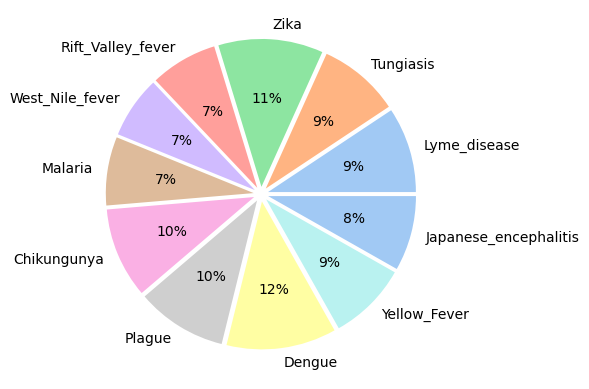

In [6]:
# declaring data
data = train_df.groupby(by='prognosis')['id'].count()
keys = train_df['prognosis'].unique()
  
# declaring exploding pie
explode = np.ones(len(data)) * 0.05
# define Seaborn color palette to use
palette_color = sns.color_palette('pastel')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')
  
# displaying chart
plt.show()

According to the graph we can see that all the label classes are somewhat equally distributed. 

### Correlation

In [7]:
palette = ['#302c36', '#037d97', '#91013E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

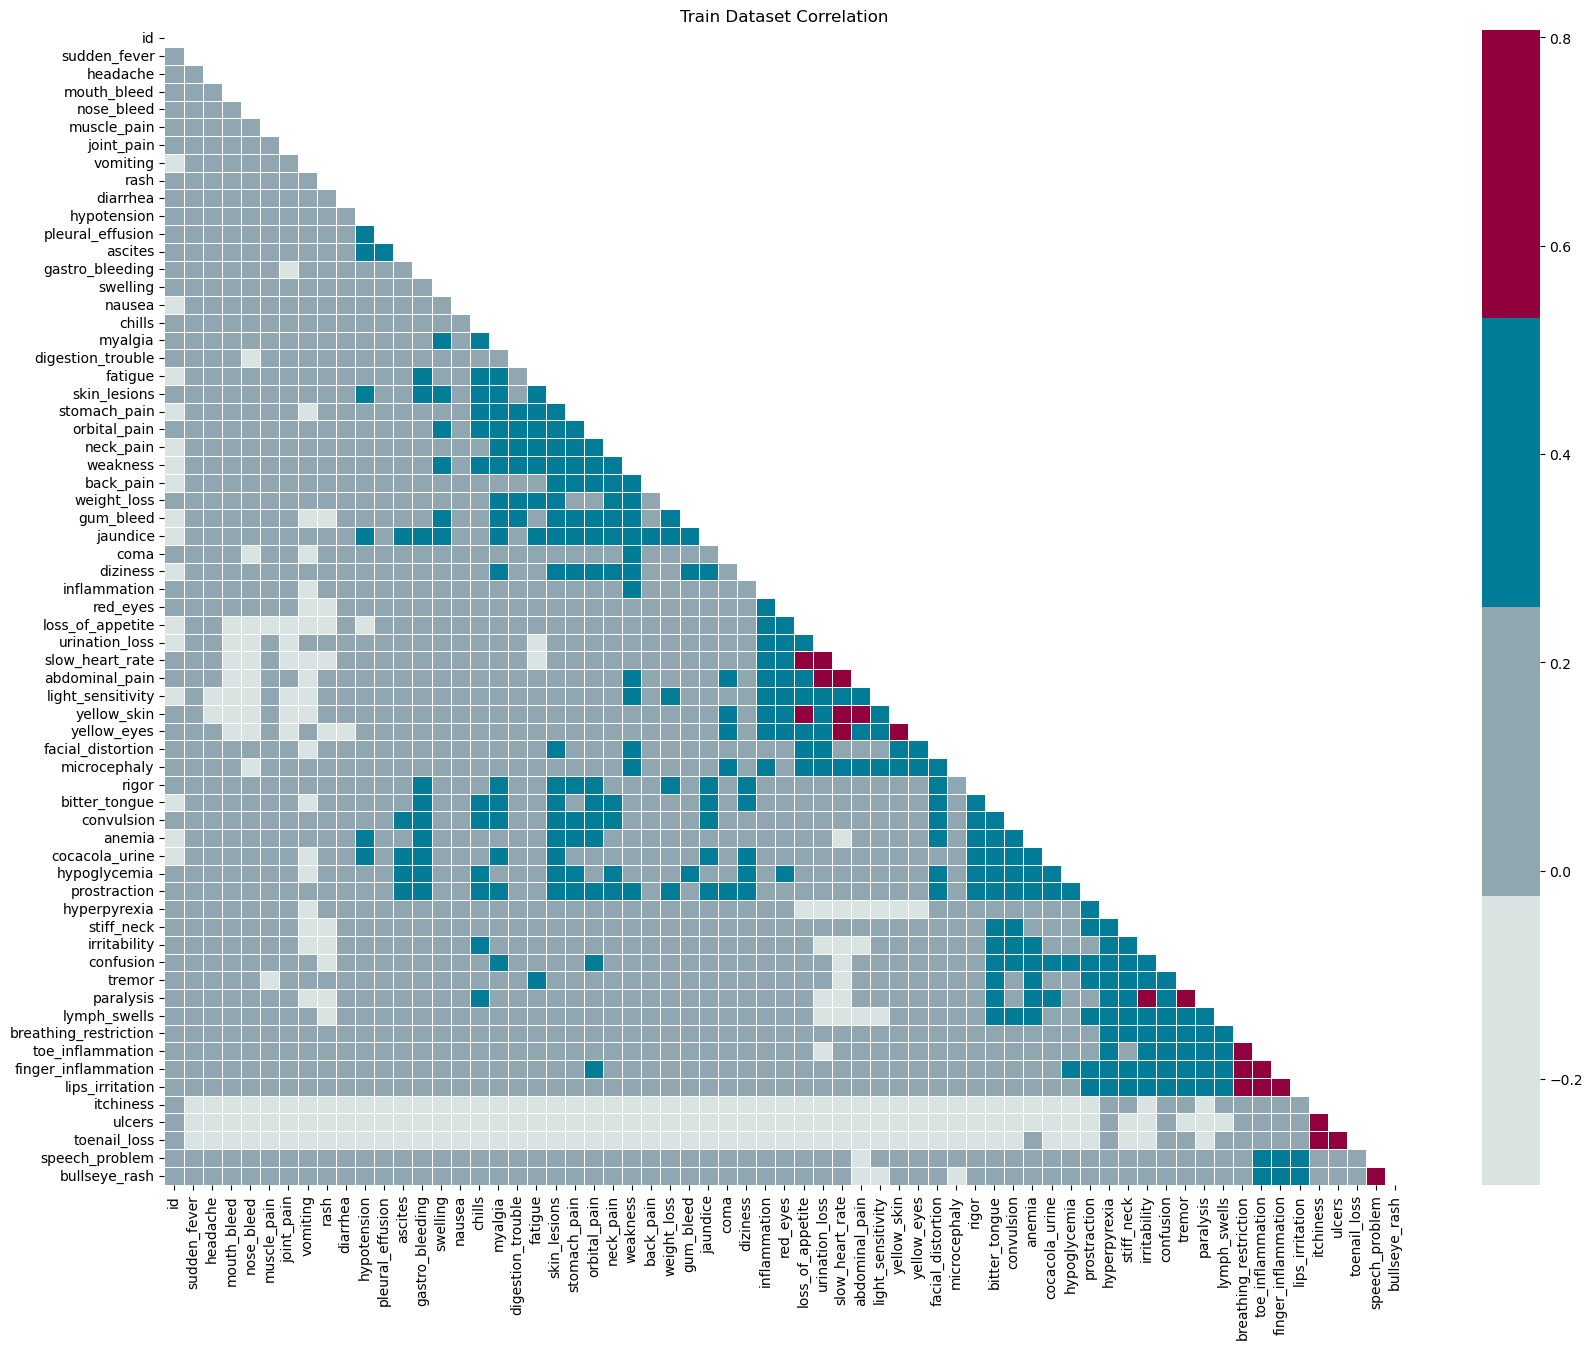

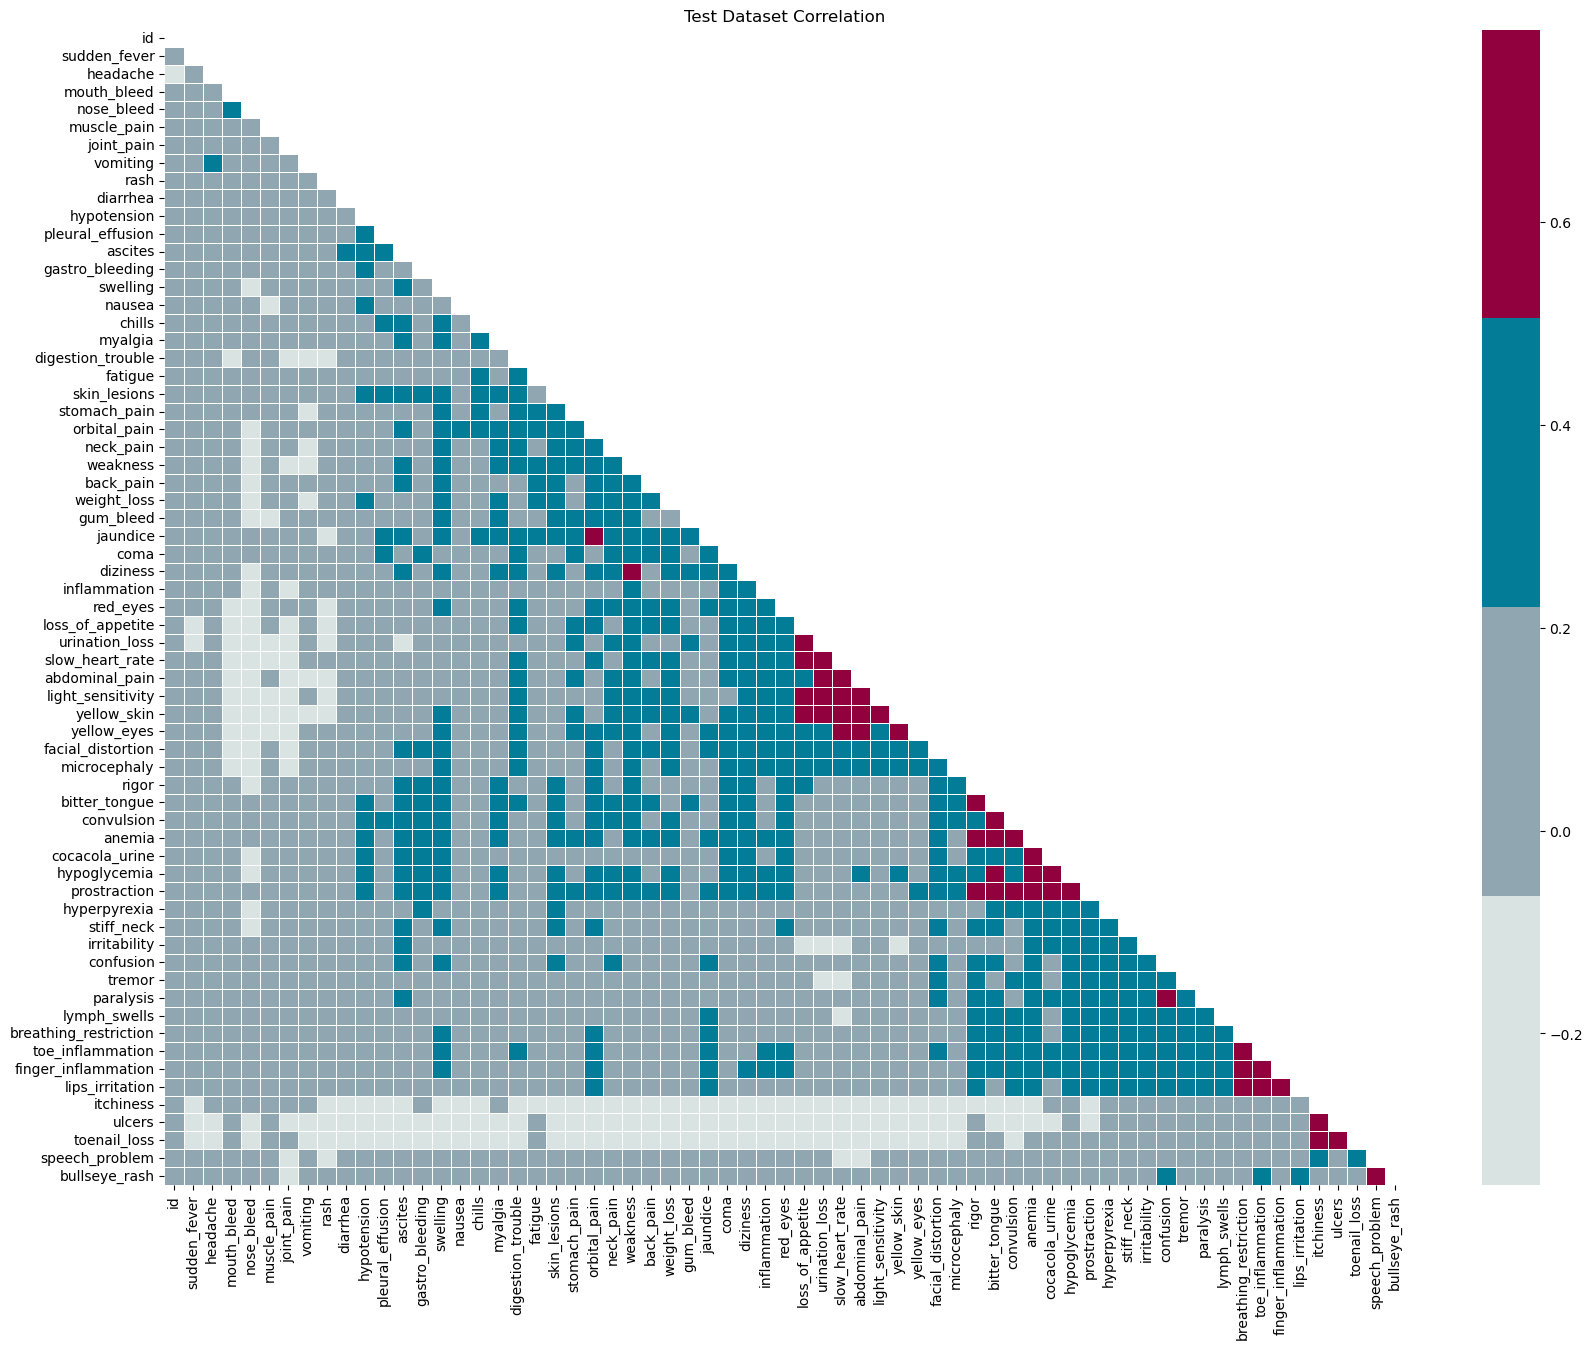

In [8]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    """Draws the correlation heatmap plot.
    
    Args:
        df: train or test dataframes
        title_name: 'Train' or 'Test' (default 'Train correlation')
        
    Returns:
        subplots of size (len(col_list), 2)
    """

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 15))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap=palette[5:][::-2] + palette[1:3], annot=False)
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(train_df, 'Train Dataset Correlation')
plot_correlation_heatmap(test_df, 'Test Dataset Correlation')

### Define the MAP@K

In [9]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


## Modeling

### Encode the labels

In [10]:
# Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df['prognosis'] = enc.fit_transform(train_df[['prognosis']])
train_df['prognosis'][:10] # Note the values here are now ordinal (floats)

0     3.0
1     7.0
2     3.0
3    10.0
4     6.0
5     3.0
6     8.0
7     7.0
8     4.0
9     0.0
Name: prognosis, dtype: float64

In [11]:
# define top 3 prediction ids.
def top_3(prediction):
    sorted_prediction_ids = np.argsort(-prediction, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:, :3]

    return top_3_prediction_ids


In [12]:
#assign feature names for respective ids
def top_3_inverse_prediction(pred_ids):
    top_3_predictions = enc.inverse_transform(pred_ids.reshape(-1,1))
    top_3_predictions = top_3_predictions.reshape(pred_ids.shape)
    
    return top_3_predictions
    

In [13]:
X = train_df.drop(columns=['prognosis', 'id'], axis=1)
y = train_df['prognosis']
test_df = test_df.drop(columns='id', axis=1)

##  XGB Model

In [14]:
kfold = KFold(n_splits=10, shuffle=True, random_state=100)
pred_xgb = np.zeros((test_df.shape[0], 11))


acc_xgb = []
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    


    # XGBoost regressor
    model_xgb = XGBClassifier(objective = 'multi:softprob',
                           colsample_bytree = 0.6, 
                           num_class=1,
                           gamma = 0.8,  
                           learning_rate = 0.01, 
                           max_depth = 3,
                           min_child_weight = 3, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(x_train, y_train)
    
    pred_xgb+= model_xgb.predict_proba(test_df)/kfold.n_splits
    val_pred_xgb = top_3(model_xgb.predict_proba(x_valid))
    acc_xgb.append(mapk(y_valid.values.reshape(-1, 1), val_pred_xgb, k=3))

    

    print(f"fold: {n+1} MAP@3 XGB Classifier: {acc_xgb[n]}")
    n+=1
print(f"final MAP@3 is :{np.mean(acc_xgb)}")

fold: 1 MAP@3 XGB Classifier: 0.35446009389671357
fold: 2 MAP@3 XGB Classifier: 0.4295774647887324
fold: 3 MAP@3 XGB Classifier: 0.3427230046948357
fold: 4 MAP@3 XGB Classifier: 0.37793427230046944
fold: 5 MAP@3 XGB Classifier: 0.39436619718309857
fold: 6 MAP@3 XGB Classifier: 0.35915492957746475
fold: 7 MAP@3 XGB Classifier: 0.32629107981220656
fold: 8 MAP@3 XGB Classifier: 0.26190476190476186
fold: 9 MAP@3 XGB Classifier: 0.3714285714285714
fold: 10 MAP@3 XGB Classifier: 0.36428571428571427
final MAP@3 is :0.3582126089872569


## CATBoost Model

In [15]:
kfold = KFold(n_splits=10, shuffle=True, random_state=100)
pred_cat = np.zeros((test_df.shape[0], 11))


acc_cat = []
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    

    
    # XGBoost regressor
    model_cat = CatBoostClassifier(loss_function='MultiClass', 
                                     n_estimators=1000, 
                                     max_depth=4, 
                                     learning_rate=0.05, 
                                     l2_leaf_reg=2, 
                                     random_seed=100).fit(x_train, y_train, verbose=False)
    
    pred_cat+= model_cat.predict_proba(test_df)/kfold.n_splits
    val_pred_cat = top_3(model_cat.predict_proba(x_valid))
    acc_cat.append(mapk(y_valid.values.reshape(-1, 1), val_pred_cat, k=3))

    

    print(f"fold: {n+1} MAP@3 CAT Classifier: {acc_cat[n]}")
    n+=1
print(f"final MAP@3 is :{np.mean(acc_cat)}")

fold: 1 MAP@3 CAT Classifier: 0.35915492957746475
fold: 2 MAP@3 CAT Classifier: 0.4107981220657277
fold: 3 MAP@3 CAT Classifier: 0.31220657276995295
fold: 4 MAP@3 CAT Classifier: 0.3568075117370892
fold: 5 MAP@3 CAT Classifier: 0.36384976525821594
fold: 6 MAP@3 CAT Classifier: 0.4389671361502347
fold: 7 MAP@3 CAT Classifier: 0.3333333333333333
fold: 8 MAP@3 CAT Classifier: 0.3357142857142857
fold: 9 MAP@3 CAT Classifier: 0.36666666666666664
fold: 10 MAP@3 CAT Classifier: 0.3904761904761905
final MAP@3 is :0.36679745137491615


## LinearDiscriminantAnalysis Model

In [16]:
kfold = KFold(n_splits=10, shuffle=True, random_state=100)
pred_lda = np.zeros((test_df.shape[0], 11))


acc_lda = []
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    
    
    

    model_lda = LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto').fit(x_train, y_train)
    
    pred_lda+= model_lda.predict_proba(test_df)/kfold.n_splits
    val_pred_lda = top_3(model_lda.predict_proba(x_valid))
    acc_lda.append(mapk(y_valid.values.reshape(-1, 1), val_pred_lda, k=3))

    

    print(f"fold: {n+1} MAP@3 LDA Classifier: {acc_lda[n]}")
    n+=1
print(f"final MAP@3 is :{np.mean(acc_lda)}")

fold: 1 MAP@3 LDA Classifier: 0.352112676056338
fold: 2 MAP@3 LDA Classifier: 0.42723004694835687
fold: 3 MAP@3 LDA Classifier: 0.3568075117370892
fold: 4 MAP@3 LDA Classifier: 0.37323943661971826
fold: 5 MAP@3 LDA Classifier: 0.4107981220657277
fold: 6 MAP@3 LDA Classifier: 0.36619718309859156
fold: 7 MAP@3 LDA Classifier: 0.3427230046948357
fold: 8 MAP@3 LDA Classifier: 0.23809523809523805
fold: 9 MAP@3 LDA Classifier: 0.38095238095238093
fold: 10 MAP@3 LDA Classifier: 0.31666666666666665
final MAP@3 is :0.3564822266934943


## Logistic Regression

In [17]:
kfold = KFold(n_splits=10, shuffle=True, random_state=100)
pred_lr = np.zeros((test_df.shape[0], 11))


acc_lr = []
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    
    
    

    model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', max_iter=1000).fit(x_train, y_train)
    
    pred_lr+= model_lr.predict_proba(test_df)/kfold.n_splits
    val_pred_lr = top_3(model_lr.predict_proba(x_valid))
    acc_lr.append(mapk(y_valid.values.reshape(-1, 1), val_pred_lr, k=3))

    

    print(f"fold: {n+1} MAP@3 LDA Classifier: {acc_lr[n]}")
    n+=1
print(f"final MAP@3 is :{np.mean(acc_lr)}")

fold: 1 MAP@3 LDA Classifier: 0.30751173708920193
fold: 2 MAP@3 LDA Classifier: 0.4295774647887323
fold: 3 MAP@3 LDA Classifier: 0.3075117370892019
fold: 4 MAP@3 LDA Classifier: 0.3169014084507042
fold: 5 MAP@3 LDA Classifier: 0.36619718309859156
fold: 6 MAP@3 LDA Classifier: 0.34037558685446007
fold: 7 MAP@3 LDA Classifier: 0.3380281690140845
fold: 8 MAP@3 LDA Classifier: 0.2476190476190476
fold: 9 MAP@3 LDA Classifier: 0.38333333333333325
fold: 10 MAP@3 LDA Classifier: 0.3142857142857142
final MAP@3 is :0.3351341381623071


In [18]:
pred_lr_top_3 = top_3(pred_lr)
pred_lr_top_3_names = top_3_inverse_prediction(pred_lr_top_3)

In [19]:
pred_lr_top_3_names

array([['Rift_Valley_fever', 'Tungiasis', 'Zika'],
       ['Dengue', 'Chikungunya', 'Malaria'],
       ['West_Nile_fever', 'Japanese_encephalitis', 'Yellow_Fever'],
       ['Japanese_encephalitis', 'Rift_Valley_fever', 'Yellow_Fever'],
       ['West_Nile_fever', 'Plague', 'Japanese_encephalitis'],
       ['Zika', 'Yellow_Fever', 'West_Nile_fever'],
       ['Malaria', 'Japanese_encephalitis', 'Plague'],
       ['Dengue', 'West_Nile_fever', 'Chikungunya'],
       ['Yellow_Fever', 'Zika', 'Plague'],
       ['Plague', 'Yellow_Fever', 'West_Nile_fever'],
       ['West_Nile_fever', 'Yellow_Fever', 'Tungiasis'],
       ['Tungiasis', 'Rift_Valley_fever', 'Zika'],
       ['Japanese_encephalitis', 'Rift_Valley_fever', 'West_Nile_fever'],
       ['Chikungunya', 'Dengue', 'Rift_Valley_fever'],
       ['West_Nile_fever', 'Plague', 'Zika'],
       ['Zika', 'Japanese_encephalitis', 'Yellow_Fever'],
       ['West_Nile_fever', 'Plague', 'Yellow_Fever'],
       ['Tungiasis', 'Rift_Valley_fever', 'Dengue

In [20]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e13/sample_submission.csv')
submission['prognosis'] = [' '.join(name) for name in pred_lr_top_3_names]
submission

,id,prognosis
0,707,Rift_Valley_fever Tungiasis Zika
1,708,Dengue Chikungunya Malaria
2,709,West_Nile_fever Japanese_encephalitis Yellow_F...
3,710,Japanese_encephalitis Rift_Valley_fever Yellow...
4,711,West_Nile_fever Plague Japanese_encephalitis
...,...,...
298,1005,Zika Yellow_Fever Tungiasis
299,1006,Malaria Lyme_disease Plague
300,1007,Lyme_disease West_Nile_fever Plague
301,1008,Zika West_Nile_fever Rift_Valley_fever


## Ensemble model

In [21]:
# def select_top_3(data):
#     ens_top_3 = []
    
#     for i in range(data.shape[0]):
#         top_3_vals = [key[0] for key in Counter(data[i]).most_common(3)]
#         ens_top_3.append(top_3_vals)
        
#     ens_top_3 = np.array(ens_top_3)
#     #top_3_pred_names_ensemble = top_3_inverse_prediction(ens_top_3)
    
#     return ens_top_3

#### lets create the ensemble model by using our models XGB, CAT and LDA

In [22]:
# pred_xgb_1 = top_3(pred_xgb)
# pred_cat_1 = top_3(pred_cat)
# pred_lda_1 = top_3(pred_lda)

In [23]:
# ensemble_values = np.concatenate((pred_xgb_1, pred_cat_1, pred_lda_1), axis=1)
# ensemble_values[:10]

In [24]:
# map_1 = []
# map_2 = []
# map_3 = []
# for i in ensemble_values:
#     map1 =[i[0], i[3], i[6]]
#     map2 = [i[1], i[4], i[7]]
#     map3 = [i[2], i[5], i[8]]
#     map_1.append(map1)
#     map_2.append(map2)
#     map_3.append(map3)

# pos_1 = []
# pos_2 = []
# pos_3 = []
# position = []
# for i in range(0,len(map_1)):
#     pos1 = [key[0] for key in Counter(map_1[i]).most_common(1)]
#     pos1 = pos1[0]

    
#     pos_check1 = [key[0] for key in Counter(map_2[i]).most_common(2)]
    
#     if pos_check1[0] == pos1:
#         pos2 = pos_check1[1]
#     else:
#         pos2 = pos_check1[0]
        

        
#     pos_check2 = [key[0] for key in Counter(map_3[i]).most_common(3)]
    
#     if pos_check2[0] == pos1:
#         if pos_check2[1] == pos2:
#             pos3 = pos_check2[2]
            
#         else:
#             pos3 = pos_check2[1]
#     else:
#         pos3 = pos_check2[0]

    
#     pos = [pos1, pos2, pos3]
#     position.append(pos)

# position = np.array(position)

In [25]:
# final_values = select_top_3(ensemble_values)
# final_names = top_3_inverse_prediction(final_values)
# final_names[:10]

In [26]:
# submission = pd.read_csv('/kaggle/input/playground-series-s3e13/sample_submission.csv')
# submission['prognosis'] = [' '.join(name) for name in final_names]

In [27]:
# submission.head()

In [28]:
submission.to_csv('submission.csv', index=False)